# Purpose of this simulation


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
import numpy as np
import aopy
import sklearn
from weights import *

# so that we write in latex
from matplotlib import rc
from weights_linear_regression import calc_R2_with_sim_C
# rc('font', **{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
from afs_files import load_feature_selection_files

import numpy as np
np.set_printoptions(precision=5, suppress=True)
sns.set_context('paper')

/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/aolab/miniconda3/envs/sijia-feature-analysis/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:8: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# ideas

In [2]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "same"
# encoder_change_mode = "change_to_zeros"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 100
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]
mean_second_peaks = [50, 110]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}'\
            for mean_second_peak in mean_second_peaks]

print(data_dump_folder)
print(exp_conds)

/home/aolab/sijia/data/figure2_simulation_setup/
['full_1.0_0_noise_32_128_50_3_clda_rho_0.5_batchlen_100_same', 'full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_same']


In [3]:

(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)
print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


In [4]:
feature_weights_all = [exp_data_all[i]['feature_selection']['feature_weights'] for i in range(len(exp_data_all))]

len(feature_weights_all)


2

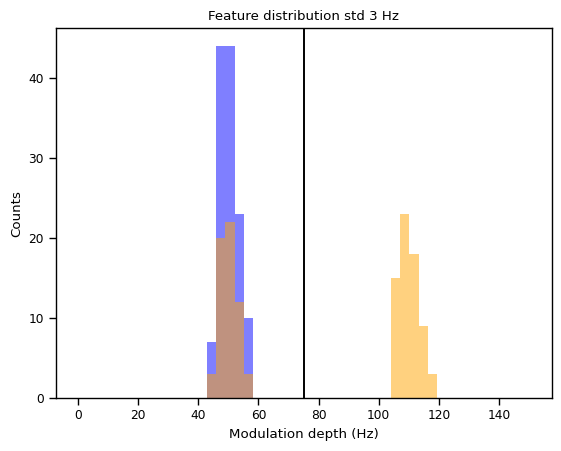

In [5]:
# plot the histogram of the feature weights

colors = ['b', 'orange']

fig_weight, ax_weight = plt.subplots()

std = 3

bins = np.linspace(0, 150, 50)

for feature_weights, c in zip(feature_weights_all, colors):

    ax_weight.hist(feature_weights, bins, color = c, label = f'{std} Hz', alpha = 0.5 )
    ax_weight.axvline(x = 75, color = 'k')
    ax_weight.set_xlabel('Modulation depth (Hz)')
    ax_weight.set_ylabel('Counts')
    ax_weight.set_title(f'Feature distribution std {std} Hz')
    
fig_weight.show()

# Check feature selection strategies

## Plot selected features across feature selection methods

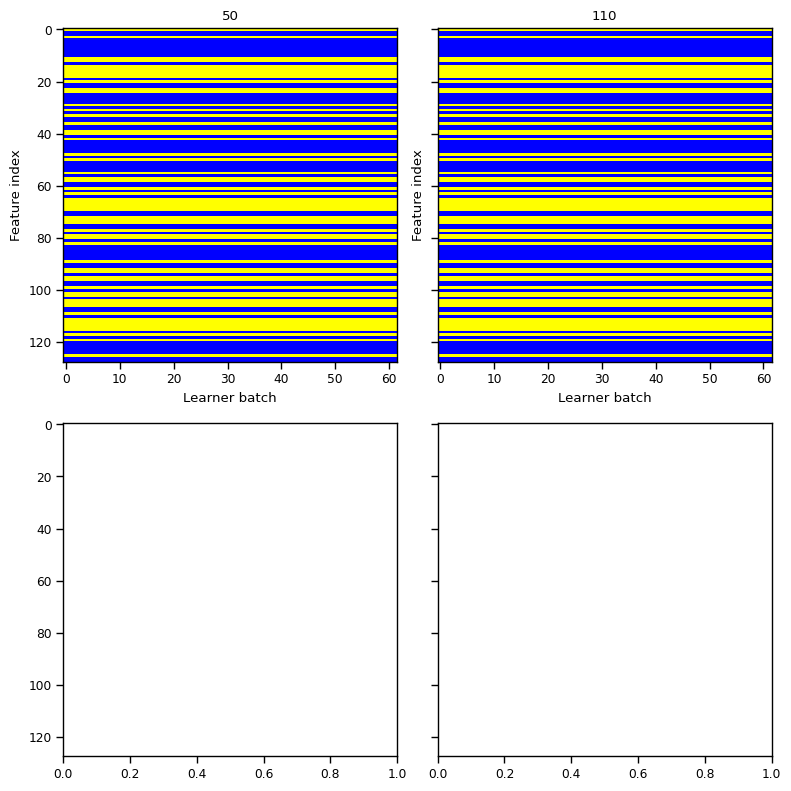

In [6]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(mean_second_peaks[i] )

    fig_feat_activity.tight_layout()

plt.show()


# Behaviour comparision

## count how many rewards

In [7]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(NUM_EXP):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    
    reward_rate_all.append(reward_rate)
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all_gap = np.array(window_time_stamps_all)
reward_rate_all_gap = np.array(reward_rate_all) 

reward_rate_all_gap = reward_rate_all_gap.reshape((NUM_EXP,-1))
window_stamps_all_gap = window_stamps_all_gap.reshape((NUM_EXP,-1))

total_rewards_all_gap = np.array(total_rewards_all)



Text(0, 0.5, 'Reward rate (rewards/min)')

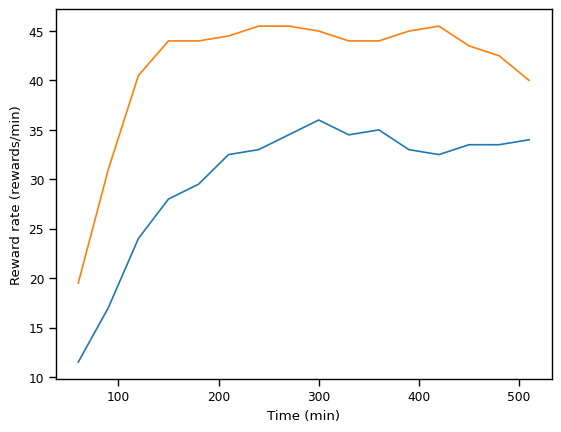

In [8]:
colors = ['blue', 'orange', 'red']

plt.plot( window_time_stamps, reward_rate_all_gap.T)
plt.xlabel('Time (min)')
plt.ylabel(r'Reward rate (rewards/min)')


## Calculate the relvance

In [9]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
    
    # get C_mat
    feature_selection_data = exp_data_all[exp_index]['feature_selection']
    C_mat = feature_selection_data["C_mat"]
    feat_set = feature_selection_data["feat_set"]
    
    # calculate R_2 over batches
    R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, intended_velocities, C_mat, feat_set, debug = False)
    
    #save  the results
    R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_gap = R_2_over_batches_all_exp.T

0
1


## Plot the cursor trajectories

In [10]:
from afs_plotting import get_all_cursor_trajectories,plot_cursor_trajectories

start_codes = range(17, 24)
print(start_codes)

cursor_trajectories_list = get_all_cursor_trajectories(exp_data_all, start_code=start_codes)


# print how many trials for each condition
for c in cursor_trajectories_list:print(len(c))


range(17, 24)
260
341


/home/aolab/sijia/adaptive_feature_selection/afs_plotting.py:181: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trial_segments = np.array(trial_segments)


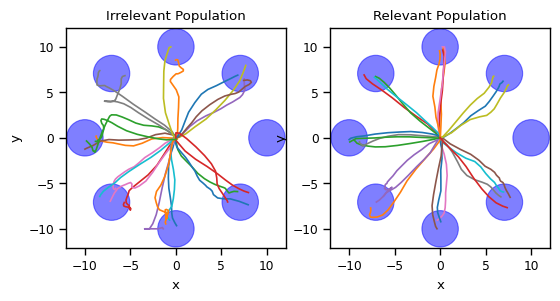

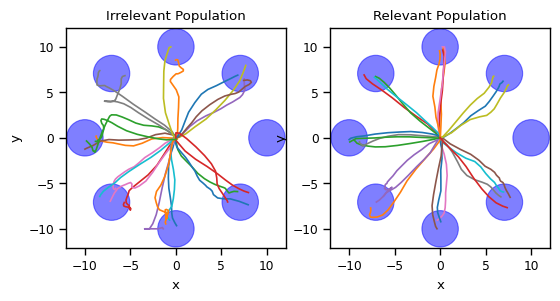

In [11]:
NUM_EXP = len(exp_data_all)

fig, axes = plt.subplots(1, NUM_EXP ,figsize=(6.25,
                                            3.25))

LAST_NUMBER_OF_TRIALS = 24
axes_titles = ['Irrelevant Population', 'Relevant Population']

for i,(ax, t) in enumerate(zip(axes, axes_titles)):
    plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                             exp_data_all[i], exp_metadata_all[i], 
                             ax = ax)
    ax.set_title(t) 

fig

## Plot a summary figure

/tmp/ipykernel_2951668/1000133744.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


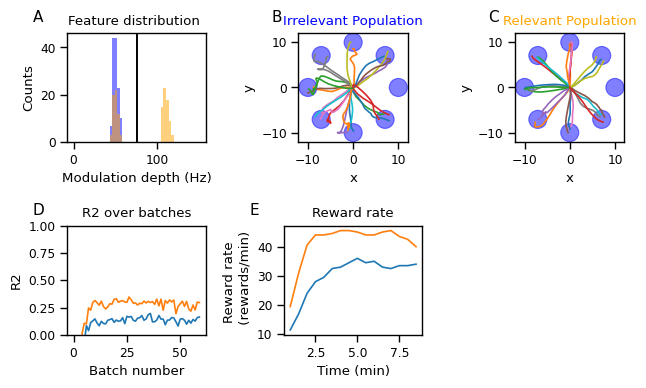

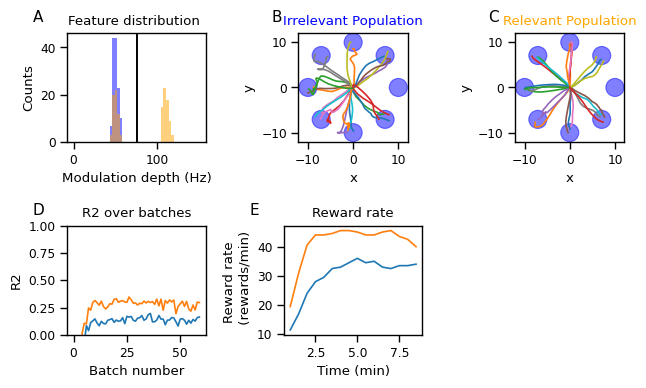

In [24]:
colors = ['b', 'orange']
# fig, axes = plt.subplots(2, 3, figsize=(6.5, 4))

fig, labels_axes = plt.subplot_mosaic("ABC;DEF", 
                                      figsize=(6.5,4),
                                      constrained_layout=True)


for n, (key, ax) in enumerate(labels_axes.items()):
    ax.text(-0.25, 1.1, key, transform=ax.transAxes, 
            size=11)

# just annotate the axes
axes = list(labels_axes.values())
axes = np.array(axes).reshape((2,3))


# First subplot
std = 3
bins = np.linspace(0, 150, 50)
axs = axes[0,0]

for feature_weights, c in zip(feature_weights_all, colors):
    axs.hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs.axvline(x=75, color='k')
    axs.set_xlabel('Modulation depth (Hz)')
    axs.set_ylabel('Counts')
    axs.set_title(f'Feature distribution ')

# the next two plots, we plot the trajectories
trajectory_axes = axes[0,1:]
LAST_NUMBER_OF_TRIALS = 24
axes_titles = ['Irrelevant Population', 'Relevant Population']
axes_title_colors = ['b', 'orange']



for i,(ax, t) in enumerate(zip(trajectory_axes, axes_titles)):
    plot_cursor_trajectories(cursor_trajectories_list[i][-LAST_NUMBER_OF_TRIALS:], 
                             exp_data_all[i], exp_metadata_all[i], 
                             ax = ax)
    ax.set_title(t, color = axes_title_colors[i])

axs = axes[1,:]

# Second subplot
axs[0].plot(R_2_over_batches_all_exp.T)
axs[0].set_title('R2 over batches')
axs[0].set_xlabel('Batch number')
axs[0].set_ylabel('R2')
axs[0].set_ylim([0, 1])

# Third subplot
axs[1].plot(window_time_stamps /60, reward_rate_all_gap.T )
axs[1].set_xlabel('Time (min)')
axs[1].set_ylabel('Reward rate \n (rewards/min)')
axs[1].set_title('Reward rate')

axs[2].set_visible(False) 

fig.tight_layout()
fig

# Analyze the encoder shuffle result

In [ ]:


data_dump_folder = \
'/home/aolab/sijia/data/figure2_simulation_setup/'

ROUND_DECIMALS = 3


random_seed = 0
n_neurons = 128
s = 1.0

# clda setup 
rho = 0.5
batch_len = 100
feature_selection_method = "full"
encoder_change_mode = "swap_top_and_bottom"

noises = [32]
fixed_noise_level = 32

# we set up the neural populations
mean_first_peak = 50
mean_second_peak = 110
std_of_peaks = 3

norm_var_2 = [mean_first_peak, mean_second_peak]

# feature_selection_method 
FEATURE_SELECTOR_TYPE = "full"
init_feat_first_or_last_all = ['first', "last"]
init_feat = "first"
exp_conds = []


exp_conds = [f'{FEATURE_SELECTOR_TYPE}_{s}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_init_{init_feat}_{encoder_change_mode}']
exp_conds_oracle = [f'Oracle_{1.0}_{random_seed}_noise_{fixed_noise_level}_{n_neurons}_{mean_second_peak}_{std_of_peaks}_clda_rho_{rho}_batchlen_{batch_len}_{encoder_change_mode}']

exp_conds += exp_conds_oracle

print(data_dump_folder)
for e in exp_conds:print(e)

/home/aolab/sijia/data/figure2_simulation_setup/
full_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_init_first_swap_top_and_bottom
Oracle_1.0_0_noise_32_128_110_3_clda_rho_0.5_batchlen_100_swap_top_and_bottom


In [ ]:
(exp_data_all, exp_metadata_all) = load_feature_selection_files(data_dump_folder, exp_conds)

print(f'we collected {len(exp_data_all)} number of experiments')

/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:382: UserWarning: Warning: no sync clock connected! This will usually result in problems.
  warnings.warn("Warning: no sync clock connected! This will usually result in problems.")
/home/aolab/sijia/analyze/aopy/preproc/bmi3d.py:449: UserWarning: No sync events present, using bmi3d events instead
  warnings.warn("No sync events present, using bmi3d events instead")


we collected 2 number of experiments


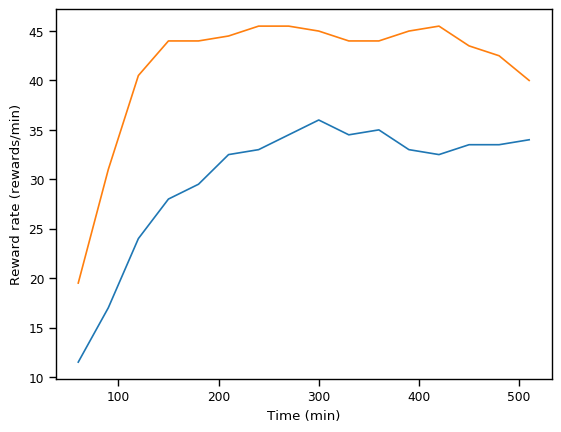

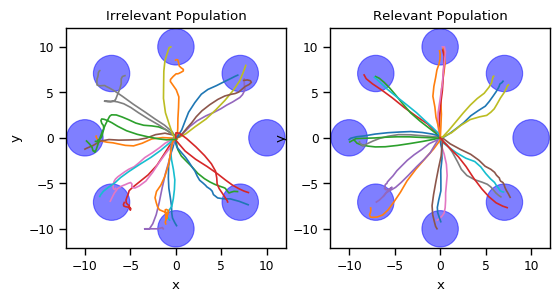

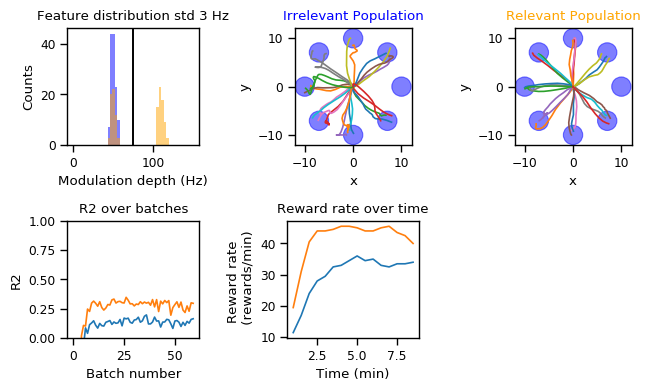

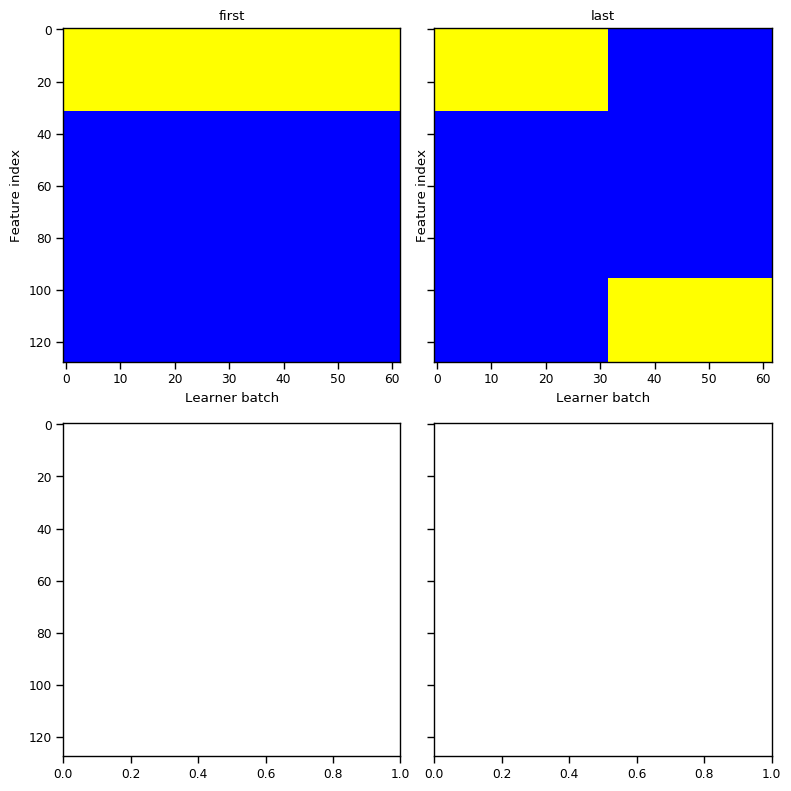

In [ ]:
import importlib 
from afs_plotting import plot_feature_selection

if len(exp_data_all) ==  1:
    plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'])
else:
    
    num_columns = len(exp_data_all)

    fig_feat_activity, ax_feat_activity = plt.subplots(2, 2, 
                                                    sharey = True,
                                                    figsize = (8, 8))



    for i, (e, a) in enumerate(zip(exp_data_all,  ax_feat_activity.flatten())):
        plot_feature_selection(e['feature_selection']['feat_set'], ax = a)
        
        a.set_title(init_feat_first_or_last_all[i])

    fig_feat_activity.tight_layout()

plt.show()

In [ ]:
threshold = 90

feature_weights = exp_data_all[0]['feature_selection']['feature_weights']
exp_data_all[0]['feature_selection'].keys()
new_sim_c = exp_data_all[0]['feature_selection']['new_sim_c']
sim_c = exp_data_all[0]['feature_selection']['sim_C']

good_features_initial = (np.linalg.norm(sim_c, axis=1) >threshold)
good_features_after_shuffled = (np.linalg.norm(new_sim_c, axis=1) >threshold)


nnum_of_repeats_before,  num_of_repeats_after= 30, 30


old_features_before_shuffled_repeat = np.repeat(good_features_initial[:, np.newaxis],
                                                nnum_of_repeats_before, axis = 1)
new_features_after_shuffled_repeat = np.repeat(good_features_after_shuffled[:, np.newaxis],
                                                num_of_repeats_after, axis = 1)

encoder_weight_change = np.concatenate((old_features_before_shuffled_repeat,
                                        new_features_after_shuffled_repeat), axis = 1)

encoder_weight_change.shape

(128, 60)

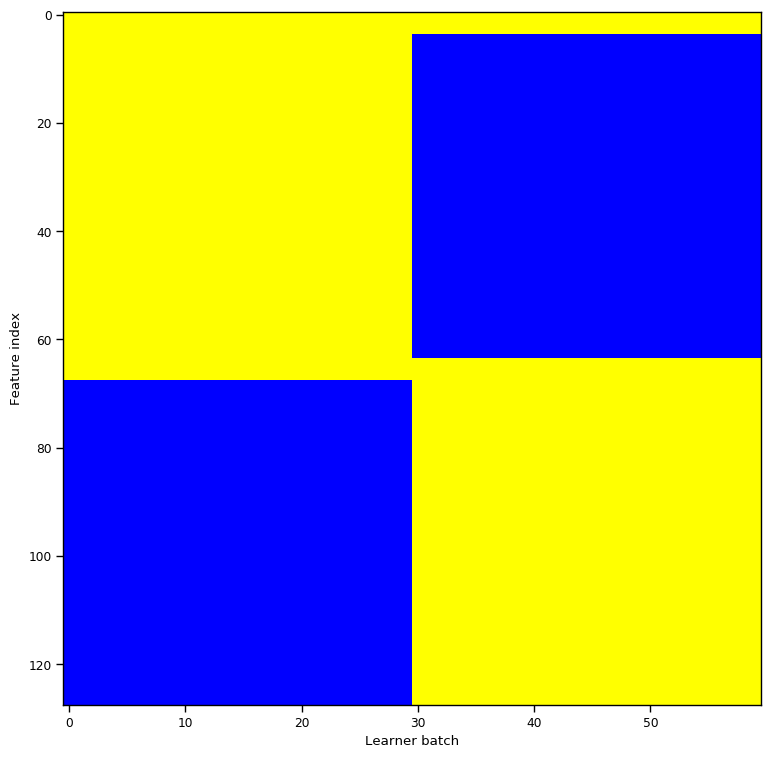

In [ ]:
summary_figure, summary_axes = plt.subplots(figsize = (9, 9))
plot_feature_selection(encoder_weight_change.T, ax = summary_axes)
summary_figure

## let's calculate the feature smoothness

In [ ]:
# next question I ask,  how many features are being selected, anyway? 
num_features_exp_by_batch = []

selected_feature_batches = [exp_data_all[i]['feature_selection']['feat_set'] for i in range(len(exp_data_all))]

for i,e in enumerate(exp_data_all):

    active_set = e['feature_selection']['feat_set']

    num_features_over_batch = np.sum(active_set, axis = 1)
    num_features_exp_by_batch.append(num_features_over_batch.copy())

num_features_exp_by_batch = np.array(num_features_exp_by_batch)
selected_feature_batches = np.array(selected_feature_batches)



print(selected_feature_batches.shape)

selected_features_conds_by_feature_batches = np.moveaxis(selected_feature_batches, 1, 2)


smoothness_conds_by_batch = \
calculate_feature_smoothness_multiple_conditions(selected_features_conds_by_feature_batches, 
                                                 mode = "incremental")

print(smoothness_conds_by_batch.shape)

(2, 62, 128)
(2, 61)


## let's calculate the reward rate

In [ ]:
fps = 60

reward_rate_all = list()
window_time_stamps_all = list()
NUM_EXP = len(exp_data_all)

total_rewards_all = list()

for i in range(len(exp_data_all)):

    time_stamps = exp_data_all[i]['events']['time'] / fps
    events = exp_data_all[i]['events']['event']
    
    
    num_rewards = np.count_nonzero(events == b'REWARD')

    (reward_rate, window_time_stamps) = aopy.analysis.calc_running_event_rate(b'REWARD', events, time_stamps, 
                                                                window_size= 120,
                                                                 window_step= 30)
    
    window_time_stamps = window_time_stamps / fps
    
    reward_rate_all.append(reward_rate )
    window_time_stamps_all.append(window_time_stamps)
    total_rewards_all.append(num_rewards)
    
    # print(num_rewards, reward_rate, window_time_stamps)


window_stamps_all = np.array(window_time_stamps_all)
reward_rate_all = np.array(reward_rate_all) 

reward_rate_all = reward_rate_all.reshape((NUM_EXP,-1))
window_stamps_all = window_stamps_all.reshape((NUM_EXP,-1))

total_rewards_all = np.array(total_rewards_all)

## let's calculate the relevance

In [ ]:
R_2_over_batches_all_exp = []


X_VEL_STATE = 3
Y_VEL_STATE = 5
CONST_STATE = 6

for exp_index in range(len(exp_data_all)):
    intended_kin = exp_data_all[exp_index]['bmi3d_clda']['intended_kin']
    spike_counts_batch = exp_data_all[exp_index]['bmi3d_clda']['spike_counts_batch']
    
    intended_velocities = intended_kin[:,(X_VEL_STATE, Y_VEL_STATE, CONST_STATE), :]
    
    # get C_mat
    feature_selection_data = exp_data_all[exp_index]['feature_selection']
    C_mat = feature_selection_data["C_mat"]
    feat_set = feature_selection_data["feat_set"]
    
    # calculate R_2 over batches
    R_2_over_batches = calc_R2_with_sim_C(spike_counts_batch, intended_velocities, C_mat, feat_set, debug = False)
    
    #save  the results
    R_2_over_batches_all_exp.append(R_2_over_batches)
    
    print(exp_index)
    
R_2_over_batches_all_exp = np.array(R_2_over_batches_all_exp)
R_2_over_batches_all_exp_shuffle = R_2_over_batches_all_exp.T

0
1


## make a summary figure for the shuffling case

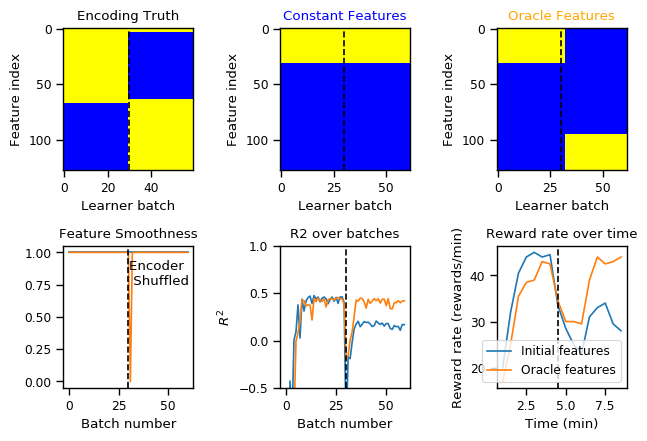

In [ ]:
# make a 2 by 3 figure
fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))

# first row are the conditions
axs[0,0].set_title('Encoding Truth')
axs[0,1].set_title('Constant Features', color = 'blue')
axs[0,2].set_title('Oracle Features', color = 'orange')

plot_feature_selection(encoder_weight_change.T, ax = axs[0,0])
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = axs[0,1])
plot_feature_selection(exp_data_all[1]['feature_selection']['feat_set'], ax = axs[0,2])

# draw dotted lines to separate the conditions
axs[0,0].axvline(x = 30, color = 'k', linestyle='--')
axs[0,1].axvline(x = 30, color = 'k', linestyle='--')
axs[0,2].axvline(x = 30, color = 'k', linestyle='--')


# second row are the results

axs[1,0].set_title("Feature Smoothness")
axs[1,1].set_title("R2 over batches")
axs[1,2].set_title("Reward rate over time")

axs[1,0].plot(smoothness_conds_by_batch.T)
axs[1,0].set_xlabel('Batch number')
axs[1,0].text(30.5, 0.9, 'Encoder \n Shuffled', ha='left', va='top',
               transform=axs[1,0].get_xaxis_transform())
axs[1,0].axvline(x = 30, color = 'k', linestyle='--')

axs[1,1].plot(R_2_over_batches_all_exp_shuffle)
axs[1,1].set_title('R2 over batches')
axs[1,1].set_xlabel('Batch number')
axs[1,1].axvline(x = 30, color = 'k', linestyle='--')
axs[1,1].set_ylabel(r'$R^2$')
axs[1,1].set_ylim([-0.5, 1])

axs[1,2].plot( window_time_stamps, reward_rate_all.T)
axs[1,2].set_xlabel('Time (min)')
axs[1,2].set_ylabel(r'Reward rate (rewards/min)')
axs[1,2].legend(['Initial features', 'Oracle features'], loc = 'lower right')
axs[1,2].axvline(x = 4.5, color = 'k', linestyle='--')

fig.tight_layout()
fig.show()
fig

# Make a summary figure

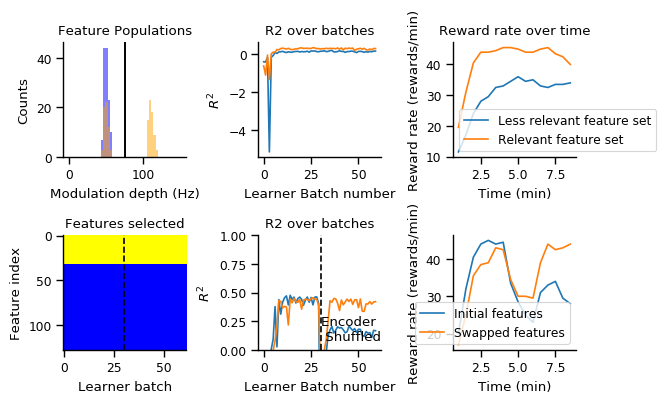

In [ ]:
FEATURE_SHUFFLING_TIME = 30
# make a summary figure


colors = ['b', 'orange']
fig_full, axes_full = plt.subplots(2, 3, figsize=(6.5, 4))

# First subplot
std = 3

axs = axes_full[0,:]

bins = np.linspace(0, 150, 50)
for feature_weights, c in zip(feature_weights_all, colors):
    axs[0].hist(feature_weights, bins, color=c, label=f'{std} Hz', alpha=0.5)
    axs[0].axvline(x=75, color='k')
    axs[0].set_xlabel('Modulation depth (Hz)')
    axs[0].set_ylabel('Counts')
    axs[0].set_title(f'Feature Populations')

# Second subplot
axs[1].plot(R_2_over_batches_all_exp_gap)
axs[1].set_title('R2 over batches')
axs[1].set_xlabel('Learner Batch number')
axs[1].set_ylabel(r'$R^2$')

# Second subplot
axs[2].plot(window_time_stamps, reward_rate_all_gap.T )  
axs[2].set_xlabel('Time (min)')
axs[2].set_ylabel('Reward rate (rewards/min)')
axs[2].legend([ 'Less relevant feature set', 'Relevant feature set'])
axs[2].set_title('Reward rate over time')
# second row, we show the plots for the shuffled rows

axs = axes_full[1,:]
plot_feature_selection(exp_data_all[0]['feature_selection']['feat_set'], ax = axs[0])
axs[0].set_title('Features selected')
axs[0].axvline(x = 30, color = 'k', linestyle='--')


# Second subplot
axs[1].plot(R_2_over_batches_all_exp_shuffle)
axs[1].set_title('R2 over batches')
axs[1].set_xlabel('Learner Batch number')
axs[1].axvline(x = 30, color = 'k', linestyle='--')
axs[1].text(30.5, 0.3, 'Encoder \n Shuffled', ha='left', va='top', transform=axs[1].get_xaxis_transform())
axs[1].set_ylabel(r'$R^2$')
axs[1].set_ylim([0, 1])

axs[2].plot( window_time_stamps, reward_rate_all.T)
axs[2].set_xlabel('Time (min)')
axs[2].set_ylabel(r'Reward rate (rewards/min)')
axs[2].legend(['Initial features', 'Swapped features'], loc = 'lower right')

sns.despine()

fig_full.tight_layout()
fig_full

In [ ]:
#fig_full.savefig('/home/aolab/sijia/adaptive_feature_selection/figure2_simulation_setup/figure2_full_feature_selection.pdf', dpi = 300)